# <a>Projeto 3 - Classificação usando Scikit Learn e XGBoost</a>

*Let's Data - Jornada Cientista da Dados*

## <a> Motivação </a>

Muitos problemas da vida real na carreira de cientista de dados são modelados como classificação. Quando nossa variável dependente é discreta, temos uma classificação. As classes podem ser somente duas (variável dependente binária) ou problemas multiclasse. 

Agora que você já criou seu primeiro modelo, sabe como separar a base, sabe que selecionar modelo é só na validação, vamos aumentar um pouquinho o nível! Criar o modelo, treinar, validar e testar é a parte mais "fácil". Escolher a melhor forma de tratar dados faltantes (missing data), realizar uma boa engenharia de features (feature engineering) e selecionar a melhor métrica para cada projeto são partes essenciais e que requerem uma certa "criatividade" de nossa parte. 

O lado bom é que esses passos são bem difíceis de automatizar e as máquinas não tomarão nossos lugares num futuro próximo :D

<img src="https://styles.redditmedia.com/t5_adbcw/styles/communityIcon_anc30b6ykk461.jpg?width=256&s=70937fbb08582ee30a1ddb13cc171b757625b4ad"/>

## <a> Objeto de Estudo </a>

Um problema muito recorrente para muitas empresas é qual a melhor forma de retenr seus clientes. Saber de antemão se um cliente vai cancelar os serviços é uma grande vantagem competitiva para qualquer empresa. A estratégia de marketing, CRM e as equipes de vendas podem se beneficiar muito se tiver informações de quais clientes tem mais chances de deixar de contratar os serviços de uma empresa.

Esse tipo de problema é chamado de previsão de churn (de churn rate, ou, % de clientes que deixam a empresa num determinado tempo). Para resolver esse tipo de problema precisamos ter uma base histórica com clientes que saíram e não saíram da empresa, bem como suas características. 

Bancos, telefônicas, varejo, qualquer empresa que presta algum tipo de serviços e possui informações sobre seus clientes pode se beneficiar de modelos preditivos similares aos que iremos construir.

Nesse projeto, vamos ajudar a Let's Talk (empresa telefônica da holding Let's Data) a manter seus clientes. Faremos isso criando modelos para classificar os clientes em "churn" ou "não churn", ou seja, se irão cancelar os serviços ou não.

![Let's Talk](img/letstalk.png)

A base utilizada pode ser obtida no [Kaggle](https://www.kaggle.com/blastchar/telco-customer-churn) e se trata de uma empresa telefônica fictícia com dados demográficos e de serviços contratados pelos  clientes com a informação se saiu ou não da empresa.

In [ ]:
#!pip install scikit-learn pandas seaborn xgboost

In [1]:
# importando as bibliotecas para leitura dos dados e criação de gráficos
import os
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns


# configurando pandas para mostrar todas as linhas e colunas
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None) 

# configurando pandas para não mostrar notação científica para números
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
# Ler os dados da telefonica. Existe uma base de testes, mas ela não tem as respostas, então não serve muito pro nosso caso
df_clientes = pd.read_csv('./data/train.csv')
df_clientes.head()

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4030,Female,0,No,No,56.00,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,NaN,45.05,2560.1,0
1,6731,Male,0,Yes,Yes,NaN,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
2,6479,Female,0,Yes,No,60.00,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.7,0
3,6861,Female,0,No,No,37.00,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
4,3266,Male,0,Yes,Yes,29.00,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.8,1


In [3]:
df_clientes.columns

Index(['id', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Cada linha é um cliente, portanto, vamos verificar se isso é fato?

In [4]:
df_clientes['id'].is_unique

True

De fato, é uma linha por cliente ;)

Entendendo as colunas:
- id: identificação do cliente
- gender: sexo do cliente
- SeniorCitizen: indicador se é um(a) idoso(a)
- Partner: indicador se tem um parceiro(a)
- Dependents: indicador se possui dependentes
- tenure: quantos meses o cliente está na empresa
- PhoneService: indicador se possui serviços de telefonia
- MultipleLines: indicador se possui múltiplas linhas telefônicas
- InternetService: indicador se possui serviços de internet
- OnlineSecurity: indicador se possui serviços de segurança online
- OnlineBackup: indicador se possui serviços de backup online
- DeviceProtection: indicador se possui serviços de proteção de equipamentos
- TechSupport: indicador se possui serviços de suporte técnico
- StreamingTV: indicador se possui serviços de streaming de tv
- StreamingMovies: indicador se possui serviços de streaming de filmes
- Contract: tipo de contrato
- PaperlessBilling: indicador se a cobrança é via papel ou não (cobrança eletrônica)
- PaymentMethod: indicador do tipo de pagamento
- MonthlyCharges: valor mensal dos serviços
- TotalCharges: valor total dos serviços desde o início do contrato
- Churn: indicador se saiu da empresa ou não

In [5]:
df_clientes.head()

,id,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,4030,Female,0,No,No,56.00,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,NaN,45.05,2560.1,0
1,6731,Male,0,Yes,Yes,NaN,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
2,6479,Female,0,Yes,No,60.00,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.7,0
3,6861,Female,0,No,No,37.00,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
4,3266,Male,0,Yes,Yes,29.00,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.8,1


In [6]:
# Vamos transformar id em indice do dataframe
df_clientes = df_clientes.set_index('id')
df_clientes.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
id,,,,,,,,,,,,,,,,,,,,
4030,Female,0,No,No,56.00,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,NaN,45.05,2560.1,0
6731,Male,0,Yes,Yes,NaN,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
6479,Female,0,Yes,No,60.00,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.7,0
6861,Female,0,No,No,37.00,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
3266,Male,0,Yes,Yes,29.00,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.8,1


In [7]:
# Avaliando a quantidade de linhas e colunas
df_clientes.shape

(5634, 20)

In [8]:
# Avaliando os tipos
df_clientes.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                 int64
dtype: object

In [9]:
df_clientes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 4030 to 103
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5634 non-null   object 
 1   SeniorCitizen     5634 non-null   int64  
 2   Partner           5634 non-null   object 
 3   Dependents        5416 non-null   object 
 4   tenure            5173 non-null   float64
 5   PhoneService      5634 non-null   object 
 6   MultipleLines     5634 non-null   object 
 7   InternetService   5634 non-null   object 
 8   OnlineSecurity    5634 non-null   object 
 9   OnlineBackup      5634 non-null   object 
 10  DeviceProtection  5634 non-null   object 
 11  TechSupport       5634 non-null   object 
 12  StreamingTV       5634 non-null   object 
 13  StreamingMovies   5634 non-null   object 
 14  Contract          5634 non-null   object 
 15  PaperlessBilling  5634 non-null   object 
 16  PaymentMethod     5535 non-null   object

TotalCharges está como object, mas deveria ser float, vamos fazer a conversão

In [11]:
df_clientes['TotalCharges'].dtype

dtype('O')

In [12]:
df_clientes['TotalCharges'].value_counts()

20.2       8
           8
19.55      7
19.75      6
19.9       6
19.45      6
19.65      6
20.05      6
20.25      6
45.3       5
20.15      5
44.4       4
69.6       4
20.3       4
50.15      4
19.3       4
44         4
20.45      4
19.2       4
69.65      4
45.7       3
1284.2     3
20.4       3
70.1       3
49.9       3
19.85      3
470.2      3
74.35      3
20.1       3
50.45      3
35.9       3
24.4       3
50.75      3
69.55      3
74.6       3
19.95      3
220.45     3
69.9       3
20.35      3
85.5       3
70.45      3
74.7       3
69.95      3
80.55      3
75.3       3
69.1       3
70.6       3
69.25      3
45.1       3
19.5       3
383.65     3
44.75      3
25.25      3
70.3       3
1077.5     2
71.65      2
79.15      2
5714.2     2
96.8       2
20.95      2
235.05     2
4858.7     2
2104.55    2
75.35      2
2661.1     2
330.8      2
92.75      2
20.5       2
2560.1     2
469.65     2
223.15     2
300.4      2
398.55     2
86.6       2
70         2
42.9       2
145.15     2

In [13]:
# Vamos tirar todos os espaços primeiro. Usando expressão regular simples \s é qualquer
# caractere de espaço, seja espaço simples ou tabulação. \s+ pega uma ou mais sequências de espaços em braco
df_clientes['TotalCharges'] = df_clientes['TotalCharges'].replace("\s+", "", regex=True)

In [14]:
df_clientes['TotalCharges'].value_counts()

20.2       8
           8
19.55      7
19.75      6
19.9       6
19.45      6
19.65      6
20.05      6
20.25      6
45.3       5
20.15      5
44.4       4
69.6       4
20.3       4
50.15      4
19.3       4
44         4
20.45      4
19.2       4
69.65      4
45.7       3
1284.2     3
20.4       3
70.1       3
49.9       3
19.85      3
470.2      3
74.35      3
20.1       3
50.45      3
35.9       3
24.4       3
50.75      3
69.55      3
74.6       3
19.95      3
220.45     3
69.9       3
20.35      3
85.5       3
70.45      3
74.7       3
69.95      3
80.55      3
75.3       3
69.1       3
70.6       3
69.25      3
45.1       3
19.5       3
383.65     3
44.75      3
25.25      3
70.3       3
1077.5     2
71.65      2
79.15      2
5714.2     2
96.8       2
20.95      2
235.05     2
4858.7     2
2104.55    2
75.35      2
2661.1     2
330.8      2
92.75      2
20.5       2
2560.1     2
469.65     2
223.15     2
300.4      2
398.55     2
86.6       2
70         2
42.9       2
145.15     2

In [15]:
# Tentando converter para float
df_clientes['TotalCharges'].astype(float)

ValueError: could not convert string to float: 

In [16]:
# Não funcionou porque existem valores que não conseguem ter conversão para float
df_clientes.loc[df_clientes['TotalCharges'] == '']

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
id,,,,,,,,,,,,,,,,,,,,
6755,Male,0,No,Yes,0.00,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,0
5219,Male,0,Yes,Yes,0.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6671,Female,0,Yes,Yes,0.00,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0
937,Female,0,Yes,Yes,0.00,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
3827,Male,0,Yes,Yes,0.00,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
1083,Male,0,Yes,Yes,0.00,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
3332,Male,0,Yes,Yes,0.00,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
1341,Female,0,Yes,Yes,0.00,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0


In [17]:
# Para converter podemos utilizar o to_numeric com coerção de error (famoso forçar a barra)
pd.to_numeric(df_clientes['TotalCharges'], errors='coerce')

id
4030   2560.10
6731    332.65
6479   6640.70
6861   3545.35
3266   1974.80
6368   3442.80
5830   1848.80
4476     61.05
1508   1008.70
2921   6155.40
3145    110.15
333    4422.95
2140    458.10
3427     69.80
3379   6033.10
3163   1394.55
6471    345.50
2350   6565.85
3756    318.90
305    3141.70
6458    792.15
1124   1611.00
670    4039.30
878    3077.00
1507   3794.50
2258   4847.05
4152   3094.05
4416   4428.45
2989   7880.25
520     265.45
5701   2414.55
4982    712.75
2187    862.40
3008   2276.95
956      44.70
2866   7082.50
982     808.95
3762   5919.35
2295   1253.90
4733   1397.30
979    6383.35
192     531.00
676    7246.15
3451   7308.95
4322   1058.10
3331   4913.30
6666   1224.05
925    1820.90
3090   5646.60
5755    454.05
741    2879.90
4226    158.35
2020   7040.85
1471    156.85
1109   1678.05
832     963.95
3482    214.55
5644     75.90
6152    672.55
5899    800.30
6918   6052.25
3610   6423.00
2474    119.30
3220    571.75
1693    947.75
4811   1424.95
3122   

In [18]:
# Pegando os índices das linhas que tem nulos pra saber como o to_numeric converte
indices_total_charges_nulo = df_clientes.loc[df_clientes['TotalCharges'] == ''].index
indices_total_charges_nulo

Int64Index([6755, 5219, 6671, 937, 3827, 1083, 3332, 1341], dtype='int64', name='id')

In [19]:
# Filtrando pelos índices pra ver como o to_numeric realiza a coerção de erros
pd.to_numeric(df_clientes['TotalCharges'], errors='coerce')[indices_total_charges_nulo]

id
6755   NaN
5219   NaN
6671   NaN
937    NaN
3827   NaN
1083   NaN
3332   NaN
1341   NaN
Name: TotalCharges, dtype: float64

In [20]:
# Ótimo! Ele "força a barra" pra converter tudo que não é numérico para NaN (not a number - "isso não é um número")
df_clientes['TotalCharges'] = pd.to_numeric(df_clientes['TotalCharges'], errors='coerce')

In [21]:
df_clientes.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure              float64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

## <a> Começando com estatística descritiva </a>

Conhecer bem as medidas estatísticas, de tendência central, dispersão, separatrizes, distribuições, é essencial para conhecermos melhor os dados em que estamos trabalhando. Qual a distribuição de tenure? Da cobrança mensal? Da cobrança total? A base está desbalanceada?

In [22]:
df_clientes.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,5634.00,5173.00,5634.00,5626.00,5634.00
mean,0.16,32.33,64.63,2273.51,0.27
std,0.37,24.46,30.02,2258.38,0.44
min,0.00,0.00,18.25,18.80,0.00
25%,0.00,9.00,35.46,401.59,0.00
50%,0.00,29.00,70.25,1396.12,0.00
75%,0.00,55.00,89.80,3764.29,1.00
max,1.00,72.00,118.75,8684.80,1.00


SeniorCitizen e Churn são discretas, mas por serem float acabou entrando na dança: vamos ignorar.

Podemos perceber que tenure tem máximo de 72 meses (6 anos). Podemos inferir que os dados foram coletados com essa janela.

<AxesSubplot:xlabel='tenure', ylabel='Count'>

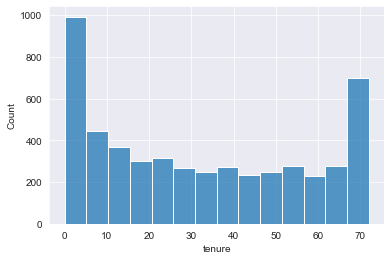

In [23]:
# Analisando a distribuição de tenure (meses na empresa)
sns.set_style("darkgrid")
plt.tight_layout()

sns.histplot(data=df_clientes, x='tenure' )

In [29]:
# Temos muitos valores próximos a zero, vamos avaliar?

len(df_clientes.loc[df_clientes['tenure'] <= 5])

992

In [31]:
100 * len(df_clientes.loc[df_clientes['tenure'] <= 5]) / df_clientes.shape[0]

17.607383741569045

In [26]:
# Mudando o padrão de quartis para decis. linspace divide em espaços iguais um intervalo de números (0 a 1 com 11 intervalos)
df_clientes.describe(percentiles=np.linspace(0, 1, 11))

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn
count,5634.00,5173.00,5634.00,5626.00,5634.00
mean,0.16,32.33,64.63,2273.51,0.27
std,0.37,24.46,30.02,2258.38,0.44
min,0.00,0.00,18.25,18.80,0.00
0%,0.00,0.00,18.25,18.80,0.00
10%,0.00,2.00,20.05,85.50,0.00
20%,0.00,6.00,25.10,267.00,0.00
30%,0.00,12.00,45.80,550.98,0.00
40%,0.00,20.00,58.60,939.80,0.00
50%,0.00,29.00,70.25,1396.12,0.00


<AxesSubplot:xlabel='MonthlyCharges', ylabel='Count'>

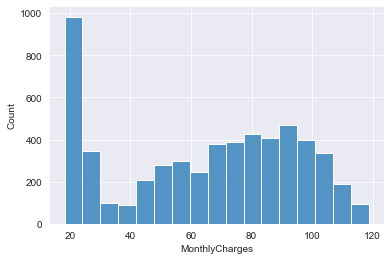

In [32]:
# Analisando a distribuição da cobrança mensal
sns.set_style("darkgrid")
plt.tight_layout()

sns.histplot(data=df_clientes, x='MonthlyCharges')

<AxesSubplot:xlabel='TotalCharges', ylabel='Count'>

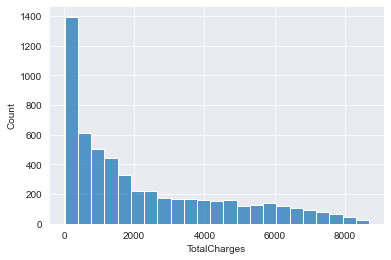

In [33]:
# Analisando a distribuição da cobrança total
sns.set_style("darkgrid")
plt.tight_layout()

sns.histplot(data=df_clientes, x='TotalCharges')


<AxesSubplot:xlabel='Churn', ylabel='count'>

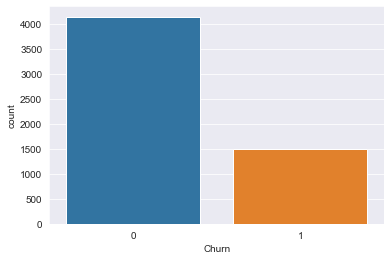

In [34]:
# Analisando a variável target: churn (cancelou os serviços da empresa ou não)
sns.countplot(data=df_clientes, x='Churn')

Temos uma base bastante desbalanceada. Temos que tomar cuidado com a métrica a ser utilizada. Vamos avaliar o desbalanceamento.

In [35]:
len(df_clientes.loc[df_clientes['Churn'] == 0]), len(df_clientes.loc[df_clientes['Churn'] == 1])

(4139, 1495)

In [36]:
# Se o modelo chutar tudo como "não saiu da empresa"
100 * len(df_clientes.loc[df_clientes['Churn'] == 0]) / df_clientes.shape[0]

73.46467873624424

Ou seja, acurácia perto de 73% quer dizer que usamos machine learning pra nada :D

## <a> Relação entre as features e a variável target </a>

Uma análise interessante é avaliar relações entre as variáveis preditoras com a target. Vamos analisar as dispersões das variáveis preditoras com o churn

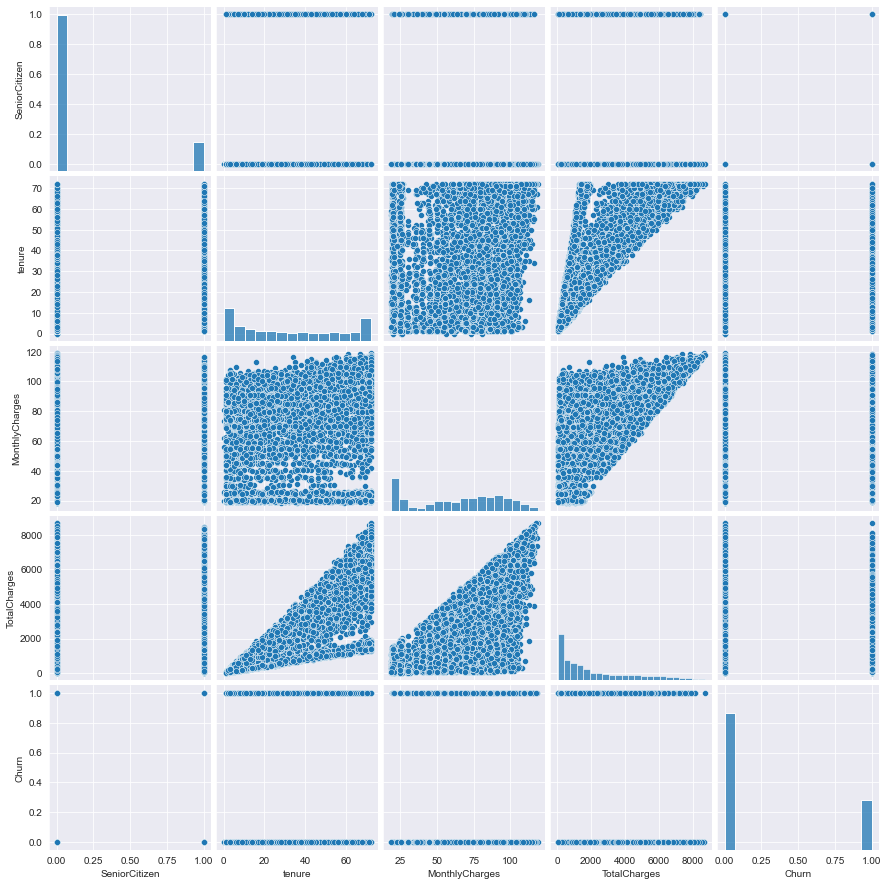

In [37]:
# O pairplot faz gráficos de dispersão para os pares de variáveis (incluindo a target)
# Na diagonal principal ele mostra o histograma
sns.pairplot(data=df_clientes)

Fica evidente uma correlação positiva entre tenure e cobranças totais (o que é bem óbvio). Além disso, nada que chame muito a atenção com relação à variável target. Como ela é categórica, se tivéssemos um gráfico que nem o abaixo, poderíamos inferir uma correlação forte:

![Gráfico com Correlação](img/grafico1.png)

## <a> Codificação de Variáveis Categóricas </a>

Lembrando que os modelos de machine learning não sabem o que são categorias em sua maioria, devemos, portanto, codificar as variáveis de sexo, parceiro(a), dependentes, tipo de cobrança e todos os tipos de serviço.

In [38]:
df_clientes.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
id,,,,,,,,,,,,,,,,,,,,
4030,Female,0,No,No,56.00,No,No phone service,DSL,Yes,Yes,Yes,Yes,No,No,Two year,No,NaN,45.05,2560.10,0
6731,Male,0,Yes,Yes,NaN,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.65,332.65,0
6479,Female,0,Yes,No,60.00,Yes,Yes,Fiber optic,No,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),110.80,6640.70,0
6861,Female,0,No,No,37.00,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),101.90,3545.35,1
3266,Male,0,Yes,Yes,29.00,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.75,1974.80,1


Vamos analisar quantas classes possuem as variáveis categóricas para saber como codificar cada uma

In [40]:
df_clientes._get_numeric_data().columns

Index(['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn'], dtype='object')

In [41]:
# Exemplo de list comprehension
[coluna for coluna in df_clientes.columns]

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [42]:
colunas_categoricas = [coluna for coluna in df_clientes.columns if coluna not in df_clientes._get_numeric_data().columns]
colunas_categoricas

['gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [43]:
for coluna_categorica in colunas_categoricas:
    display(df_clientes[coluna_categorica].value_counts())

Male      2849
Female    2785
Name: gender, dtype: int64

No     2902
Yes    2732
Name: Partner, dtype: int64

No     3793
Yes    1623
Name: Dependents, dtype: int64

Yes    5082
No      552
Name: PhoneService, dtype: int64

No                  2692
Yes                 2390
No phone service     552
Name: MultipleLines, dtype: int64

Fiber optic    2451
DSL            1959
No             1224
Name: InternetService, dtype: int64

No                     2763
Yes                    1647
No internet service    1224
Name: OnlineSecurity, dtype: int64

No                     2488
Yes                    1922
No internet service    1224
Name: OnlineBackup, dtype: int64

No                     2480
Yes                    1930
No internet service    1224
Name: DeviceProtection, dtype: int64

No                     2793
Yes                    1617
No internet service    1224
Name: TechSupport, dtype: int64

No                     2240
Yes                    2170
No internet service    1224
Name: StreamingTV, dtype: int64

No                     2218
Yes                    2192
No internet service    1224
Name: StreamingMovies, dtype: int64

Month-to-month    3084
Two year          1358
One year          1192
Name: Contract, dtype: int64

Yes    3312
No     2322
Name: PaperlessBilling, dtype: int64

Electronic check             1887
Mailed check                 1272
Bank transfer (automatic)    1212
Credit card (automatic)      1164
Name: PaymentMethod, dtype: int64

As variáveis gender, partner, dependents, phone service e paperless billing, possuem duas classes (sim ou não). Podemos então mapeá-las diretamente:

In [44]:
# Mapear gender, partner, dependents, phone service e paperless billing
df_clientes['gender'] = df_clientes['gender'].map({'Female': 1, 'Male': 0})

colunas_binarias = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']

for coluna_binaria in colunas_binarias:
    df_clientes[coluna_binaria] = df_clientes[coluna_binaria].map({'Yes': 1, 'No': 0})

    

In [45]:
# Será que funcionou?

display(df_clientes['gender'].value_counts())

for colunas_binaria in colunas_binarias:
    display(df_clientes[colunas_binaria].value_counts())

0    2849
1    2785
Name: gender, dtype: int64

0    2902
1    2732
Name: Partner, dtype: int64

0.00    3793
1.00    1623
Name: Dependents, dtype: int64

1    5082
0     552
Name: PhoneService, dtype: int64

1    3312
0    2322
Name: PaperlessBilling, dtype: int64

Por que Dependents ficou diferente?

In [46]:
df_clientes.loc[:, colunas_binarias + ['gender']].isnull().sum()

Partner               0
Dependents          218
PhoneService          0
PaperlessBilling      0
gender                0
dtype: int64

Para as outras variáveis podemos avaliar quais podem ser ordinais para utilizar a codificação ordinal.

In [47]:
# Atualizando as colunas que ainda são categóricas
colunas_categoricas = [coluna for coluna in df_clientes.columns if coluna not in df_clientes._get_numeric_data()]
colunas_categoricas

['MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaymentMethod']

In [48]:
for coluna_categorica in colunas_categoricas:
    display(df_clientes[coluna_categorica].value_counts())

No                  2692
Yes                 2390
No phone service     552
Name: MultipleLines, dtype: int64

Fiber optic    2451
DSL            1959
No             1224
Name: InternetService, dtype: int64

No                     2763
Yes                    1647
No internet service    1224
Name: OnlineSecurity, dtype: int64

No                     2488
Yes                    1922
No internet service    1224
Name: OnlineBackup, dtype: int64

No                     2480
Yes                    1930
No internet service    1224
Name: DeviceProtection, dtype: int64

No                     2793
Yes                    1617
No internet service    1224
Name: TechSupport, dtype: int64

No                     2240
Yes                    2170
No internet service    1224
Name: StreamingTV, dtype: int64

No                     2218
Yes                    2192
No internet service    1224
Name: StreamingMovies, dtype: int64

Month-to-month    3084
Two year          1358
One year          1192
Name: Contract, dtype: int64

Electronic check             1887
Mailed check                 1272
Bank transfer (automatic)    1212
Credit card (automatic)      1164
Name: PaymentMethod, dtype: int64

Podemos inferir que Contract é ordinal, pois possui claramente uma diferença entre os tipos de contrato mensais, anuais e bianuais. Outras que podemos (forçando um pouquinho a barra) são InternetService e PaymentMethod. A 1a porque tendo em vista que fibra ótica normalmente é mais rápida que ADSL (e provavelmente mais cara também). A 2a porque podemos avaliar a facilidade de cobrança pelo correio ser mais difícil/lenta que as mais automáticas e eletrônicas

In [49]:
df_clientes['Contract'] = df_clientes['Contract'].map({'Month-to-month': 0, 'One year': 1, 'Two year': 2})
df_clientes['InternetService'] = df_clientes['InternetService'].map({'No': 0, 'DSL': 1, 'Fiber optic': 2})
df_clientes['PaymentMethod'] = df_clientes['PaymentMethod'].map({'Mailed check': 0, 
                                                                 'Electronic check': 1, 
                                                                 'Bank transfer (automatic)': 2,
                                                                 'Credit card (automatic)': 3})
df_clientes.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
id,,,,,,,,,,,,,,,,,,,,
4030,1,0,0,0.00,56.00,0,No phone service,1,Yes,Yes,Yes,Yes,No,No,2,0,NaN,45.05,2560.10,0
6731,0,0,1,1.00,NaN,1,No,0,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,1,0,0.00,19.65,332.65,0
6479,1,0,1,0.00,60.00,1,Yes,2,No,Yes,Yes,Yes,Yes,Yes,2,1,3.00,110.80,6640.70,0
6861,1,0,0,0.00,37.00,1,Yes,2,No,Yes,Yes,No,Yes,Yes,0,1,2.00,101.90,3545.35,1
3266,0,0,1,1.00,29.00,1,No,2,No,No,No,No,No,No,0,1,1.00,70.75,1974.80,1


In [50]:
df_clientes.dtypes

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents          float64
tenure              float64
PhoneService          int64
MultipleLines        object
InternetService       int64
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract              int64
PaperlessBilling      int64
PaymentMethod       float64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

Para os outros, vamos de one hot encoding

In [51]:
# Atualizando as colunas que ainda são categóricas
colunas_categoricas = [coluna for coluna in df_clientes.columns if coluna not in df_clientes._get_numeric_data()]
colunas_categoricas

['MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

In [52]:
# Vamos utilizar OHE para variáveis categóricas nominais
from sklearn.preprocessing import OneHotEncoder

In [53]:
ohe = OneHotEncoder(sparse=False, drop='first')
df_ohe_transformadas = ohe.fit_transform(df_clientes[colunas_categoricas])
ohe.categories_

[array(['No', 'No phone service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object),
 array(['No', 'No internet service', 'Yes'], dtype=object)]

In [54]:
ohe.get_feature_names_out()

array(['MultipleLines_No phone service', 'MultipleLines_Yes',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes'],
      dtype=object)

Bem melhor assim! Vamos então apensar essas novas colunas no dataframe de clientes e remover as colunas originais

In [56]:
df_ohe_transformadas

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 0.]])

In [57]:
# Tranformando o array numpy em colunas.
df_ohe_transformadas = pd.DataFrame(data=df_ohe_transformadas, columns=ohe.get_feature_names_out(), index=df_clientes.index)
df_ohe_transformadas.head()

,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
id,,,,,,,,,,,,,,
4030,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
6731,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
6479,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00
6861,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
3266,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [59]:
df_clientes.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
id,,,,,,,,,,,,,,,,,,,,
4030,1,0,0,0.00,56.00,0,No phone service,1,Yes,Yes,Yes,Yes,No,No,2,0,NaN,45.05,2560.10,0
6731,0,0,1,1.00,NaN,1,No,0,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,1,0,0.00,19.65,332.65,0
6479,1,0,1,0.00,60.00,1,Yes,2,No,Yes,Yes,Yes,Yes,Yes,2,1,3.00,110.80,6640.70,0
6861,1,0,0,0.00,37.00,1,Yes,2,No,Yes,Yes,No,Yes,Yes,0,1,2.00,101.90,3545.35,1
3266,0,0,1,1.00,29.00,1,No,2,No,No,No,No,No,No,0,1,1.00,70.75,1974.80,1


In [58]:
df_ohe_transformadas.shape

(5634, 14)

In [60]:
# Utilizando o concat para realizar um "JOIN" entre os dataframes original e com as colunas com one hot encoding
# axis=0 ele apensaria as linhas, axis=1 ele junta as colunas
df_clientes = pd.concat([df_clientes, df_ohe_transformadas], axis=1)
df_clientes.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4030,1,0,0,0.00,56.00,0,No phone service,1,Yes,Yes,Yes,Yes,No,No,2,0,NaN,45.05,2560.10,0,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
6731,0,0,1,1.00,NaN,1,No,0,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,1,0,0.00,19.65,332.65,0,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
6479,1,0,1,0.00,60.00,1,Yes,2,No,Yes,Yes,Yes,Yes,Yes,2,1,3.00,110.80,6640.70,0,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00
6861,1,0,0,0.00,37.00,1,Yes,2,No,Yes,Yes,No,Yes,Yes,0,1,2.00,101.90,3545.35,1,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
3266,0,0,1,1.00,29.00,1,No,2,No,No,No,No,No,No,0,1,1.00,70.75,1974.80,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [61]:
colunas_categoricas

['MultipleLines',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies']

In [62]:
# Agora precisamos remover as colunas originais!
df_clientes = df_clientes.drop(colunas_categoricas, axis=1)
df_clientes.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
id,,,,,,,,,,,,,,,,,,,,,,,,,,,
4030,1,0,0,0.00,56.00,0,1,2,0,NaN,45.05,2560.10,0,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
6731,0,0,1,1.00,NaN,1,0,1,0,0.00,19.65,332.65,0,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
6479,1,0,1,0.00,60.00,1,2,2,1,3.00,110.80,6640.70,0,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00
6861,1,0,0,0.00,37.00,1,2,0,1,2.00,101.90,3545.35,1,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
3266,0,0,1,1.00,29.00,1,2,0,1,1.00,70.75,1974.80,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [63]:
df_clientes.dtypes

gender                                    int64
SeniorCitizen                             int64
Partner                                   int64
Dependents                              float64
tenure                                  float64
PhoneService                              int64
InternetService                           int64
Contract                                  int64
PaperlessBilling                          int64
PaymentMethod                           float64
MonthlyCharges                          float64
TotalCharges                            float64
Churn                                     int64
MultipleLines_No phone service          float64
MultipleLines_Yes                       float64
OnlineSecurity_No internet service      float64
OnlineSecurity_Yes                      float64
OnlineBackup_No internet service        float64
OnlineBackup_Yes                        float64
DeviceProtection_No internet service    float64
DeviceProtection_Yes                    

#### UFA! Tudo prontinho, variáveis todas numéricas!!

## <a> Determinando quem são variáveis preditoras e variável target </a>

Variáveis preditoras: X; variável target: y.

In [64]:
df_clientes.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'InternetService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes'],
      dtype='object')

In [65]:
X = df_clientes.drop('Churn', axis=1) # tirando a variável dependente
y = df_clientes[['Churn']] # extraindo a variável dependente

In [66]:
# Variáveis preditoras (ou independentes ou, features)
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
id,,,,,,,,,,,,,,,,,,,,,,,,,,
4030,1,0,0,0.00,56.00,0,1,2,0,NaN,45.05,2560.10,1.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00
6731,0,0,1,1.00,NaN,1,0,1,0,0.00,19.65,332.65,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00
6479,1,0,1,0.00,60.00,1,2,2,1,3.00,110.80,6640.70,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00
6861,1,0,0,0.00,37.00,1,2,0,1,2.00,101.90,3545.35,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,1.00,0.00,1.00
3266,0,0,1,1.00,29.00,1,2,0,1,1.00,70.75,1974.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [67]:
# Variável dependente, ou target, ou label (ah, vcs entenderam :)
y.head()

,Churn
id,
4030,0
6731,0
6479,0
6861,1
3266,1


## <a> Separação de bases </a>

Vamos separar logo essas bases?? Isso evita tratamento de missing data (valores faltantes), por exemplo, e tais transformações deve ser realizadas DEPOIS do split (separação).

In [68]:
# A função que separa nossa base em treino e teste! 
# Lembrando que faremos cross validation com a base de treino
from sklearn.model_selection import train_test_split

In [69]:
# Devolve uma tupla com 4 elementos: X de treino, X de teste, y de treino, y de teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, # preditoras 
                                                        y, # target
                                                        test_size=.2, 
                                                        random_state=42)

# Vamos ver quantas linhas ficamos com treino e teste
X_treino.shape, X_teste.shape, y_treino.shape, y_teste.shape

((4507, 26), (1127, 26), (4507, 1), (1127, 1))

In [70]:
X_treino.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
id,,,,,,,,,,,,,,,,,,,,,,,,,,
3559,0,0,1,NaN,28.00,1,2,1,0,2.00,92.20,2568.15,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
896,0,0,0,0.00,30.00,1,2,0,1,NaN,94.30,2679.70,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3600,1,0,1,1.00,45.00,1,1,0,0,0.00,81.30,3541.10,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00
6991,0,0,1,0.00,36.00,1,2,0,1,1.00,93.60,3366.05,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
5455,1,1,1,0.00,1.00,1,2,0,1,1.00,69.55,69.55,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [71]:
y_treino.head()

,Churn
id,
3559,0
896,0
3600,0
6991,0
5455,1


In [72]:
X_treino.shape[0] / X.shape[0]

0.7999645012424565

## <a> Tratamento de dados faltantes (missing data) </a>

In [73]:
# isnull busca quem é nulo (dados faltantes)
X_treino.isnull().sum()

gender                                    0
SeniorCitizen                             0
Partner                                   0
Dependents                              171
tenure                                  366
PhoneService                              0
InternetService                           0
Contract                                  0
PaperlessBilling                          0
PaymentMethod                            78
MonthlyCharges                            0
TotalCharges                              6
MultipleLines_No phone service            0
MultipleLines_Yes                         0
OnlineSecurity_No internet service        0
OnlineSecurity_Yes                        0
OnlineBackup_No internet service          0
OnlineBackup_Yes                          0
DeviceProtection_No internet service      0
DeviceProtection_Yes                      0
TechSupport_No internet service           0
TechSupport_Yes                           0
StreamingTV_No internet service 

In [74]:
X_teste.isnull().sum()

gender                                   0
SeniorCitizen                            0
Partner                                  0
Dependents                              47
tenure                                  95
PhoneService                             0
InternetService                          0
Contract                                 0
PaperlessBilling                         0
PaymentMethod                           21
MonthlyCharges                           0
TotalCharges                             2
MultipleLines_No phone service           0
MultipleLines_Yes                        0
OnlineSecurity_No internet service       0
OnlineSecurity_Yes                       0
OnlineBackup_No internet service         0
OnlineBackup_Yes                         0
DeviceProtection_No internet service     0
DeviceProtection_Yes                     0
TechSupport_No internet service          0
TechSupport_Yes                          0
StreamingTV_No internet service          0
StreamingTV

#### Existem diversas formas de tratar missing data, as formas podem inclusive ser testadas (com cross validation) para avaliar qual é a mais robusta para performance do modelo. Vamos testar algumas durante os treinamentos.

In [75]:
# 1o o mais simples: utilizar as medidas de tendência central!!
# Antes disso vamos guardar os X originais para tentar outras formas mais tarde
X_treino_original = X_treino.copy()
X_teste_original = X_teste.copy()

y_treino_original = y_treino.copy()
y_teste_original = y_teste.copy()

In [76]:
X_treino.loc[:, X_treino.isnull().sum() > 0].columns

Index(['Dependents', 'tenure', 'PaymentMethod', 'TotalCharges'], dtype='object')

In [77]:
X_teste.loc[:, X_teste.isnull().sum() > 0].columns

Index(['Dependents', 'tenure', 'PaymentMethod', 'TotalCharges'], dtype='object')

In [80]:
# Para as variáveis numéricas, vamos utilizar a mediana, para as categóricas, a moda
mediana_tenure = X_treino['tenure'].median()
mediana_dependents = X_treino['Dependents'].median()
mediana_total_charges = X_treino['TotalCharges'].median()
moda_payment_method = X_treino['PaymentMethod'].value_counts().index[0]

mediana_tenure, mediana_dependents, mediana_total_charges, moda_payment_method

(29.0, 0.0, 1389.6, 1.0)

In [83]:
X_treino.loc[X_treino['tenure'].isnull(), 'tenure'] = mediana_tenure
X_treino.loc[X_treino['Dependents'].isnull(), 'Dependents'] = mediana_dependents
X_treino.loc[X_treino['TotalCharges'].isnull(), 'TotalCharges'] = mediana_total_charges
X_treino.loc[X_treino['PaymentMethod'].isnull(), 'PaymentMethod'] = moda_payment_method

X_treino.isnull().sum()

gender                                  0
SeniorCitizen                           0
Partner                                 0
Dependents                              0
tenure                                  0
PhoneService                            0
InternetService                         0
Contract                                0
PaperlessBilling                        0
PaymentMethod                           0
MonthlyCharges                          0
TotalCharges                            0
MultipleLines_No phone service          0
MultipleLines_Yes                       0
OnlineSecurity_No internet service      0
OnlineSecurity_Yes                      0
OnlineBackup_No internet service        0
OnlineBackup_Yes                        0
DeviceProtection_No internet service    0
DeviceProtection_Yes                    0
TechSupport_No internet service         0
TechSupport_Yes                         0
StreamingTV_No internet service         0
StreamingTV_Yes                   

In [84]:
# Não podemos calcular medidas de tendência central com a base toda! Temos que utilizar o que
# foi calculado na base de treino
X_teste.loc[X_teste['tenure'].isnull(), 'tenure'] = mediana_tenure # computado no treino
X_teste.loc[X_teste['Dependents'].isnull(), 'Dependents'] = mediana_dependents # computado no treino
X_teste.loc[X_teste['TotalCharges'].isnull(), 'TotalCharges'] = mediana_total_charges # computado no treino
X_teste.loc[X_teste['PaymentMethod'].isnull(), 'PaymentMethod'] = moda_payment_method # computado no treino

X_teste.isnull().sum()

gender                                  0
SeniorCitizen                           0
Partner                                 0
Dependents                              0
tenure                                  0
PhoneService                            0
InternetService                         0
Contract                                0
PaperlessBilling                        0
PaymentMethod                           0
MonthlyCharges                          0
TotalCharges                            0
MultipleLines_No phone service          0
MultipleLines_Yes                       0
OnlineSecurity_No internet service      0
OnlineSecurity_Yes                      0
OnlineBackup_No internet service        0
OnlineBackup_Yes                        0
DeviceProtection_No internet service    0
DeviceProtection_Yes                    0
TechSupport_No internet service         0
TechSupport_Yes                         0
StreamingTV_No internet service         0
StreamingTV_Yes                   

## <a> Vamos de Machine Learning? </a>

Primeiro modelo que vamos treinar é a regressão logística! A prima esquisita da regressão linear, que nem pra regressão serve, mas sim pra classificação! Lembrando que vamos utilizar cross validation para evitar overfit e ter uma base de comparação para outros modelos

In [85]:
# Veja como Regressão Logística está no pacotão de modelos lineares!
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [86]:
# Criando o estimador, algoritmo, modelo, preditor, classificador (virge, que tanto de nome!)
# Vamos alterar o número de iterações para cálculo da regressão logística, pois no default ele enche de warnings
# que pode não ter chegado na melhor solução
regressao_logistica = LogisticRegression(max_iter=500)

In [88]:
type(regressao_logistica)

sklearn.linear_model._logistic.LogisticRegression

In [89]:
# Vamos treinar utilizando cross validation
valores_f1_rl = cross_val_score(estimator=regressao_logistica, 
                                  X=X_treino, 
                                  y=y_treino.values.flatten(), 
                                  cv=10, # 10-fold CV
                                  scoring='f1') # f1 score porque a base está desbalanceada
valores_f1_rl

array([0.61946903, 0.61802575, 0.60262009, 0.55111111, 0.6367713 ,
       0.64377682, 0.68122271, 0.58035714, 0.53846154, 0.61261261])

In [90]:
len(valores_f1_rl)

10

In [91]:
media_f1_rl = valores_f1_rl.mean()
f'f1-score: {media_f1_rl*100}'

'f1-score: 60.844281019066294'

### Vamos tentar agora com random forest?

In [92]:
# Modelo de bagging mais famoso!
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

# Vamos treinar utilizando cross validation (sempre!!)
valores_f1_rf = cross_val_score(estimator=random_forest, 
                                      X=X_treino, 
                                      y=y_treino.values.flatten(), 
                                      cv=10, # 
                                  scoring='f1')
valores_f1_rf

array([0.61032864, 0.55963303, 0.58119658, 0.47663551, 0.62672811,
       0.63348416, 0.61395349, 0.55924171, 0.54545455, 0.61971831])

In [93]:
media_f1_rf = valores_f1_rf.mean()
f'f1-score: {media_f1_rf*100}'


'f1-score: 58.26374084577798'

### Finalmente, o famoso XGBoost

In [94]:
import xgboost as xgb

In [95]:
xgb_model = xgb.XGBClassifier(random_state=42, 
                              objective='binary:logistic', 
                              use_label_encoder=False, 
                              eval_metric='error')

In [96]:
type(xgb_model)

xgboost.sklearn.XGBClassifier

In [97]:
# Vamos treinar utilizando cross validation (sempre!!)
valores_f1_xgb = cross_val_score(estimator=xgb_model, 
                                      X=X_treino, 
                                      y=y_treino.values.flatten(), 
                                      cv=10, # 
                                  scoring='f1')
valores_f1_xgb

array([0.55605381, 0.60344828, 0.58723404, 0.48181818, 0.57009346,
       0.59728507, 0.5814978 , 0.56140351, 0.54716981, 0.59459459])

In [98]:
media_f1_xgb = valores_f1_xgb.mean()

f'f1-score: {media_f1_xgb*100}'

'f1-score: 56.805985497539716'

### Fueeeeen :D

Vamos de regressão logística e testar um pouco de feature engineering


## <a> Feature Engineering </a>

Nesse momento em que separamos quem só sabe fazer as coisas no automático e quem realmente se debruça sobre o problema a ser atacado. Vamos avaliar alguns possíveis insights do problema em questão.

Vamos começar com a imputação de dados faltantes? Será que conseguimos melhorar algo?

In [99]:
# Revisitando os dados faltantes (antes do split)
X.isnull().sum()

gender                                    0
SeniorCitizen                             0
Partner                                   0
Dependents                              218
tenure                                  461
PhoneService                              0
InternetService                           0
Contract                                  0
PaperlessBilling                          0
PaymentMethod                            99
MonthlyCharges                            0
TotalCharges                              8
MultipleLines_No phone service            0
MultipleLines_Yes                         0
OnlineSecurity_No internet service        0
OnlineSecurity_Yes                        0
OnlineBackup_No internet service          0
OnlineBackup_Yes                          0
DeviceProtection_No internet service      0
DeviceProtection_Yes                      0
TechSupport_No internet service           0
TechSupport_Yes                           0
StreamingTV_No internet service 

### Insights

Perceberam que tenure tem um número considerável de dados faltantes. Mas, se pararmos pra pensar, temos a cobrança total e a cobrança mensal. Será que podemos utilizar esses valores para inferir algo melhor que somente a mediana? Ora, se dividirmos a cobrança total pelo valor mensal, teremos uma estimativa muito boa de quantos meses o cliente está com serviço contratado (tenure). Vamos testar

In [100]:
# Buscando somente a coluna tenure para deixar o resto das imputações iguais
X_treino['tenure'] = X_treino_original['tenure']
X_teste['tenure'] = X_teste_original['tenure']

In [101]:
X_treino['tenure'].isnull().sum()

366

In [102]:
X_teste['tenure'].isnull().sum()

95

In [103]:
X_treino.loc[X_treino['tenure'].isna(), 'tenure'] = X_treino.loc[X_treino['tenure'].isna(), 'TotalCharges'] / X_treino.loc[X_treino['tenure'].isna(), 'MonthlyCharges']

In [104]:
len(X_treino.loc[X_treino['tenure'].isna()])

0

In [105]:
# Testando modelo com diferente missing data para tenure
rl_2 = LogisticRegression(max_iter=500)

# Vamos treinar utilizando cross validation
valores_f1_rl2 = cross_val_score(estimator=rl_2, 
                                  X=X_treino, 
                                  y=y_treino.values.flatten(), 
                                  cv=10, # 10-fold CV
                                  scoring='f1')
valores_f1_rl2

array([0.63755459, 0.64935065, 0.60606061, 0.56637168, 0.6460177 ,
       0.6440678 , 0.6779661 , 0.61135371, 0.58095238, 0.64      ])

In [106]:
media_f1_rl2 = valores_f1_rl2.mean()

f'f1-score: {media_f1_rl2*100}'

'f1-score: 62.59695212142925'

### Outros tipos de imputação

Uma outra forma de imputar é utilizando um modelo preditivo para inferir os dados faltantes! Vamos tentar isso para a variável Dependents? Para tal, vamos utilizar imputação utilizando K nearest neighbors, um algoritmo simples que busca similaridades entre pontos "vizinhos" para predizer alguma valor ou classe. No nosso problema, o algoritmo vai prever os dependentes dos clientes que não tem essa informação com base na similaridade desse cliente com outros. Vamos testar também!

In [107]:
# Buscando o X original de novo! Como vamos mudar somente a coluna de Dependents, vamos buscar somente essa coluna
X_treino['Dependents'].isnull().sum()

0

In [108]:
X_treino['Dependents'] = X_treino_original['Dependents']
X_treino['Dependents'].isnull().sum()

171

In [109]:
X_treino.isnull().sum()

gender                                    0
SeniorCitizen                             0
Partner                                   0
Dependents                              171
tenure                                    0
PhoneService                              0
InternetService                           0
Contract                                  0
PaperlessBilling                          0
PaymentMethod                             0
MonthlyCharges                            0
TotalCharges                              0
MultipleLines_No phone service            0
MultipleLines_Yes                         0
OnlineSecurity_No internet service        0
OnlineSecurity_Yes                        0
OnlineBackup_No internet service          0
OnlineBackup_Yes                          0
DeviceProtection_No internet service      0
DeviceProtection_Yes                      0
TechSupport_No internet service           0
TechSupport_Yes                           0
StreamingTV_No internet service 

In [110]:
# imputação fica em "impute"
from sklearn.impute import KNNImputer

imputacao_knn = KNNImputer(n_neighbors=2)
treino_imputado = imputacao_knn.fit_transform(X_treino)
treino_imputado

array([[0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

In [111]:
imputacao_knn.feature_names_in_

array(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'InternetService', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No internet service', 'OnlineBackup_Yes',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'StreamingMovies_Yes'],
      dtype=object)

In [112]:
treino_imputado.shape

(4507, 26)

In [113]:
treino_imputado[:, 3]

array([0.5, 0. , 1. , ..., 0.5, 1. , 1. ])

In [114]:
X_treino['Dependents'] = treino_imputado[:, 3]
X_treino['Dependents'].isnull().sum()

0

In [115]:
X_treino.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
id,,,,,,,,,,,,,,,,,,,,,,,,,,
3559,0,0,1,0.50,28.00,1,2,1,0,2.00,92.20,2568.15,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
896,0,0,0,0.00,30.00,1,2,0,1,1.00,94.30,2679.70,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3600,1,0,1,1.00,45.00,1,1,0,0,0.00,81.30,3541.10,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00
6991,0,0,1,0.00,36.00,1,2,0,1,1.00,93.60,3366.05,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
5455,1,1,1,0.00,1.00,1,2,0,1,1.00,69.55,69.55,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [116]:
X_treino_original.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
id,,,,,,,,,,,,,,,,,,,,,,,,,,
3559,0,0,1,NaN,28.00,1,2,1,0,2.00,92.20,2568.15,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
896,0,0,0,0.00,30.00,1,2,0,1,NaN,94.30,2679.70,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3600,1,0,1,1.00,45.00,1,1,0,0,0.00,81.30,3541.10,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00
6991,0,0,1,0.00,36.00,1,2,0,1,1.00,93.60,3366.05,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00
5455,1,1,1,0.00,1.00,1,2,0,1,1.00,69.55,69.55,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


#### E lá vamos nós!!

In [117]:
# Testando modelo com diferente missing data para dependents
rl_3 = LogisticRegression(max_iter=500)

# Vamos treinar utilizando cross validation
valores_f1_rl3 = cross_val_score(estimator=rl_3, 
                                  X=X_treino, 
                                  y=y_treino.values.flatten(), 
                                  cv=10, # 10-fold CV
                                  scoring='f1')
valores_f1_rl3

array([0.63157895, 0.65217391, 0.61206897, 0.56637168, 0.6460177 ,
       0.64705882, 0.67234043, 0.60869565, 0.58215962, 0.62780269])

In [118]:
media_f1_rl3 = valores_f1_rl3.mean()


f'f1-score: {media_f1_rl3*100}'

'f1-score: 62.4626842269146'

### Última tentativa, com diversas variáveis categóricas novas (binárias)

Essa parte é muito utilizada na prática para tentar buscar padrões que só o ser humano (por enquanto) consegue avaliar. Esse conhecimento faz muita diferença e devemos nos debruçar muito no problema para criar essas variáveis "derivadas". Vamos apelar? :)

In [ ]:
X_treino.head()

In [120]:
# O cliente tem ou não tem internet
X_treino['tem_internet'] = X_treino['InternetService'].isin([1, 2]).astype(int)

# Possui alguma fidelidade?
X_treino['tem_fidelidade'] = X_treino['Contract'].isin([1, 2]).astype(int)

# Vamos contar a quantidade de serviços que o cliente tem contratado
X_treino['numero_de_servicos'] = X_treino['tem_internet'] + X_treino['OnlineSecurity_Yes'] + \
        X_treino['MultipleLines_Yes'] + X_treino['OnlineBackup_Yes'] + \
        X_treino['DeviceProtection_Yes'] + X_treino['TechSupport_Yes'] + \
        X_treino['StreamingTV_Yes'] + X_treino['StreamingMovies_Yes'] + \
        X_treino['PhoneService']

# Vamos criar um valor por media de cobrança?
X_treino['media_cobranca_por_servico'] = X_treino['MonthlyCharges'] / X_treino['numero_de_servicos']
X_treino.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,tem_internet,tem_fidelidade,numero_de_servicos,media_cobranca_por_servico
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3559,0,0,1,0.50,28.00,1,2,1,0,2.00,92.20,2568.15,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1,1,5.00,18.44
896,0,0,0,0.00,30.00,1,2,0,1,1.00,94.30,2679.70,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,1,0,6.00,15.72
3600,1,0,1,1.00,45.00,1,1,0,0,0.00,81.30,3541.10,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,1.00,0.00,0.00,1,0,8.00,10.16
6991,0,0,1,0.00,36.00,1,2,0,1,1.00,93.60,3366.05,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,1,0,5.00,18.72
5455,1,1,1,0.00,1.00,1,2,0,1,1.00,69.55,69.55,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0,2.00,34.77


In [121]:
# Testando modelo com diferente missing data para dependents
rl_4 = LogisticRegression(max_iter=500)

# Vamos treinar utilizando cross validation
valores_f1_rl4 = cross_val_score(estimator=rl_4, 
                                  X=X_treino, 
                                  y=y_treino.values.flatten(), 
                                  cv=10, # 10-fold CV
                                  scoring='f1')
valores_f1_rl4

array([0.625     , 0.65502183, 0.61403509, 0.57894737, 0.63436123,
       0.65306122, 0.64957265, 0.60444444, 0.59259259, 0.63436123])

In [122]:
media_f1_rl4 = valores_f1_rl4.mean()

f'f1-score: {media_f1_rl4*100}'

'f1-score: 62.4139766826132'

## <a> Modelo Campeão! </a>

Agora que temos um modelo campeao (que acabou sendo a regressão logística simprona com tenure imputado com total cobrança dividido pela cobrança mensal! :D), vamos treinar modelo na base de treinamento toda!


In [123]:
# Bagunçamos bastante o X_treino desde o 1o modelo, vamos retomar (seria mais fácil criar pipelines, mas mostrar os passos é importante)
X_treino = X_treino_original
X_treino.loc[X_treino['tenure'].isna(), 'tenure'] = X_treino.loc[X_treino['tenure'].isna(), 'TotalCharges'] / X_treino.loc[X_treino['tenure'].isna(), 'MonthlyCharges']
X_treino.loc[X_treino['Dependents'].isnull(), 'Dependents'] = mediana_dependents
X_treino.loc[X_treino['TotalCharges'].isnull(), 'TotalCharges'] = mediana_total_charges
X_treino.loc[X_treino['PaymentMethod'].isnull(), 'PaymentMethod'] = moda_payment_method

X_treino.isnull().sum()


gender                                  0
SeniorCitizen                           0
Partner                                 0
Dependents                              0
tenure                                  0
PhoneService                            0
InternetService                         0
Contract                                0
PaperlessBilling                        0
PaymentMethod                           0
MonthlyCharges                          0
TotalCharges                            0
MultipleLines_No phone service          0
MultipleLines_Yes                       0
OnlineSecurity_No internet service      0
OnlineSecurity_Yes                      0
OnlineBackup_No internet service        0
OnlineBackup_Yes                        0
DeviceProtection_No internet service    0
DeviceProtection_Yes                    0
TechSupport_No internet service         0
TechSupport_Yes                         0
StreamingTV_No internet service         0
StreamingTV_Yes                   

In [124]:
# Mesmo com teste
X_teste = X_teste_original
X_teste.loc[X_teste['tenure'].isna(), 'tenure'] = X_teste.loc[X_teste['tenure'].isna(), 'TotalCharges'] / X_teste.loc[X_teste['tenure'].isna(), 'MonthlyCharges']
X_teste.loc[X_teste['Dependents'].isnull(), 'Dependents'] = mediana_dependents
X_teste.loc[X_teste['TotalCharges'].isnull(), 'TotalCharges'] = mediana_total_charges
X_teste.loc[X_teste['PaymentMethod'].isnull(), 'PaymentMethod'] = moda_payment_method

X_teste.isnull().sum()


gender                                  0
SeniorCitizen                           0
Partner                                 0
Dependents                              0
tenure                                  0
PhoneService                            0
InternetService                         0
Contract                                0
PaperlessBilling                        0
PaymentMethod                           0
MonthlyCharges                          0
TotalCharges                            0
MultipleLines_No phone service          0
MultipleLines_Yes                       0
OnlineSecurity_No internet service      0
OnlineSecurity_Yes                      0
OnlineBackup_No internet service        0
OnlineBackup_Yes                        0
DeviceProtection_No internet service    0
DeviceProtection_Yes                    0
TechSupport_No internet service         0
TechSupport_Yes                         0
StreamingTV_No internet service         0
StreamingTV_Yes                   

In [125]:
regressao_logistica.fit(X_treino, y_treino.values.flatten())

LogisticRegression(max_iter=500)

In [126]:
regressao_logistica.coef_

array([[-2.33288702e-03,  3.54330702e-01, -4.80405550e-02,
        -2.12364861e-01, -7.35629264e-02, -3.39223664e-01,
         4.24428015e-01, -7.70007435e-01,  4.47259213e-01,
        -2.46914734e-02,  2.35557588e-03,  5.06489900e-04,
         8.48352947e-02,  2.38570773e-01, -1.26705152e-01,
        -5.69494472e-01, -1.26705152e-01, -2.44441897e-01,
        -1.26705152e-01, -1.73887688e-01, -1.26705152e-01,
        -4.82337867e-01, -1.26705152e-01,  1.59782505e-01,
        -1.26705152e-01,  1.12420053e-01]])

In [127]:
df_coeficientes = pd.DataFrame(regressao_logistica.coef_)
df_coeficientes.columns=regressao_logistica.feature_names_in_
df_coeficientes

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,MultipleLines_No phone service,MultipleLines_Yes,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes
0,-0.00,0.35,-0.05,-0.21,-0.07,-0.34,0.42,-0.77,0.45,-0.02,0.00,0.00,0.08,0.24,-0.13,-0.57,-0.13,-0.24,-0.13,-0.17,-0.13,-0.48,-0.13,0.16,-0.13,0.11


## <a> Finalmente </a>

Agora que temos nosso modelo final, podemos fazer inferências dos valores do churn no teste. Percebam que nunca utilizamos o teste PARA NADA, como deve ser.

In [128]:
# ver estimadores scikit learn
# estimador é treinado com fit
# estimador prediz com predict
predicoes_churn = regressao_logistica.predict(X_teste)
predicoes_churn[:5]

array([0, 0, 0, 1, 0], dtype=int64)

In [129]:
len(predicoes_churn)

1127

In [130]:
y_teste.head()

,Churn
id,
1998,0
6996,0
4668,0
2799,1
5110,0


In [131]:
predicoes_vs_real = pd.DataFrame({'predicao': predicoes_churn.flatten(), 'real': y_teste.values.flatten()})
predicoes_vs_real.head(20)

,predicao,real
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0
5,0,0
6,1,1
7,0,0
8,0,0
9,0,0


In [132]:
# Tudo muito bem, tudo muito bom. Mas será que uma simples média é melhor do 
# que nosso modelo? Vamos testar o r quadrado
from sklearn.metrics import f1_score

f1_score(y_true=y_teste, y_pred=predicoes_churn)

0.5666666666666667

56,66% de f1-score, queda no teste te mostra se vale a pena ou não utilizar o modelo em produção. Vamos dar uma olhada na acurácia, só de curiosidade? :)

In [133]:
from sklearn.metrics import accuracy_score

accuracy_score(y_true=y_teste, y_pred=predicoes_churn)

0.7923691215616682

Acima dos 73% do modelo "burrinho", algum ganho por certo.